# Tradeoff Problem Example: Podracing

We are entered in the race of the century! Just like Anakin Skywalker, we built our own podracer and are about to begin the race. The official informs us that there are certain “checkpoints” that we need to hit. Our goal is to save as much fuel as possible so we don’t run out during the race.

Before we start the race, we must figure out the appropriate thruster burns at each instant.
 * We’ll (approximately) model thrust as a 2D vector containing info on direction change
 * Amount of fuel we consume when we use thrusters is calculated as $L_2$ norm of thrust vector
 * Suppose the officials aren’t watching the checkpoints very closely, so long as we “sort of” hit the checkpoints we’ll be okay

 In this version of the problem, we'll enforce the constraints in a "soft" manner with a box of feasbility, and then we will solve this in a hierarchical manner.  To use almost a minimum amount of fuel, but try to go as fast as possible at the end of the lap

In [1]:
using JuMP, Ipopt, LinearAlgebra

k = 4              # number of checkpoints
T = zeros(Int,k)   # vector of timepoints
xw = zeros(2,k)    # vector of checkpoint locations

# times at which we must hit checkpoints
T[1] = 1
T[2] = 20
T[3] = 50
T[4] = 60

# define checkpoints' x and y coords
way_xy = [ 1   4   6   1
           1   3   0   1 ]

β = 0.1 

m = Model(Ipopt.Optimizer)  # Since we have a nonlinear constraint in the hierarchical problem, we need a new solver Ipopt
set_silent(m)

@variable(m, x[1:2,1:T[k]])  # position at each time
@variable(m, v[1:2,1:T[k]])  # velocity at each time
@variable(m, u[1:2,1:T[k]])  # thruster input at each time

# satisfy the dynamics (with zero initial velocity)
@constraint(m, v[:,1] .== [0;0])
@constraint(m, x[:,1] .== [1;1])
# model system dynamics
for t in 1:T[k]-1
    @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
    @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
end

### COMMENT AND UNCOMMENT DEPENDING ON WHETHER CHECKPOINTS ARE CONSTRAINTS ###
# hit all the checkpoints
for i in 1:k
    @constraint(m, x[:,T[i]] .<= way_xy[:,i] + β/2)
    @constraint(m, x[:,T[i]] .>= way_xy[:,i] - β/2)
end


# minimize 2-norm (THIS IS LEAST-SQUARES)
@objective(m, Min, sum(u.^2))
optimize!(m)

fuel_used = objective_value(m)
final_velocity = norm(value.(v[:,T[k]]))
xopt = value.(x)

println("fuel: ", 100*fuel_used, " final v: ", final_velocity)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

fuel: 4.0037337810488465 final v: 0.5740919741790926


## Plot Model Output

We can visualize our solution by plotting the output below:


In [2]:
# plot the solution against the checkpoints
using PyPlot

function plotRace(x)

    figure(figsize=(12,4))
    plot( x[1,:], x[2,:], "b.-", markersize=4 )
    plot( x[1,:][T], x[2,:][T], "b.", markersize=12 )
    plot( way_xy[1,:], way_xy[2,:], "r.", markersize=12 )
    axis("equal")
    axis((1.,8.,-.5,3.5));
    # Only need this in vscode?
    display(gcf())
end
;

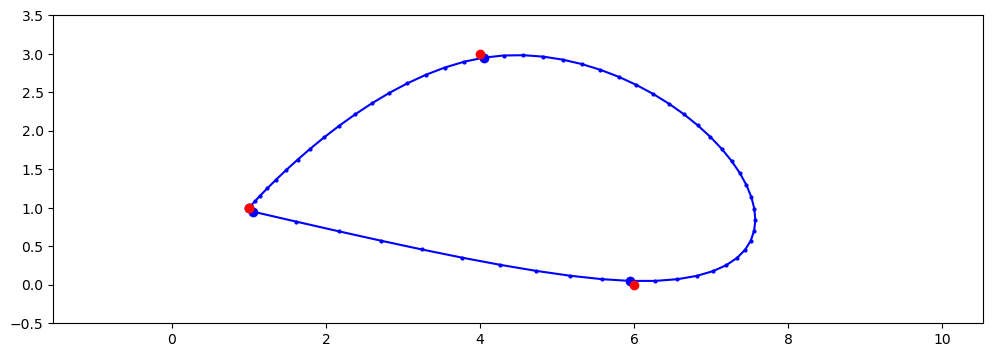

In [3]:
plotRace(xopt)


# Let's go slow

Now suppose that we have to use no more than 10% of the fuel we used, but we would like to be going as slow as possible when we reach the end (at time period 30)

Do do this, we add a constraint that
$\sum_{t \in T} \|u_t\|^2 \leq 1.1 F^*$, where $F^*$ is the optimal (smallest) amount of fuel used---obtained on our first solution.

In [4]:

@constraint(m, sum(u.^2) <= 1.1*fuel_used)

@objective(m, Min, sum(v[:,T[k]].^2))
optimize!(m)
fuel_used = value(sum(u.^2))
final_velocity = norm(value.(v[:,T[k]]))
xopt = value.(x)

println("fuel: ", 100*fuel_used, " final v: ", final_velocity)

fuel: 4.404108140778454 final v: 0.45376305571322134


Now we can plot it again.  Note that the velocity seems to be higher than the original solution

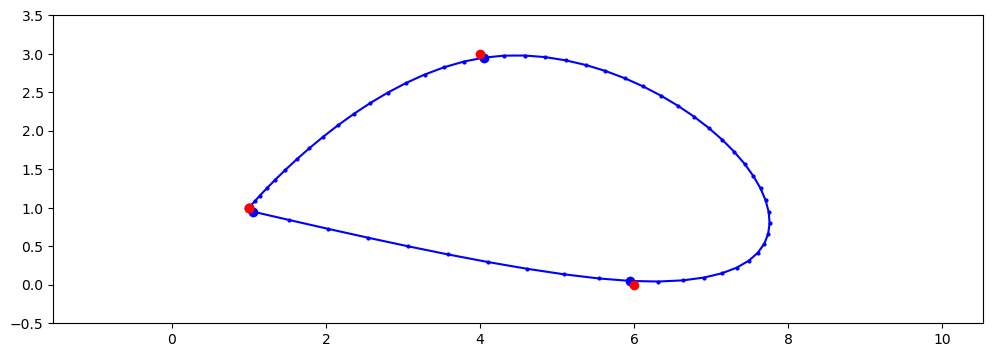

In [5]:
plotRace(xopt)